<h1 style="text-align:center;">Numerical Quantum Mechanics</h1>
<h2 style="text-align:center;">Time-Independent Schrodinger Equation using Finite Difference</h2>
<h3 style="text-align:center;">Fadjar Fathurrahman</h3>
<h3 style="text-align:center;">Mariya Al Qibtiya Nasution</h3>

In [1]:
import PyPlot
const plt = PyPlot;

In [2]:
plt.svg(true);

In [3]:
using LinearAlgebra

In [4]:
using Printf

# Introduction

**Problem** Find stationary states of the Schrodinger equation:

$$
\left[ -\frac{\hbar^2}{2m} \frac{\mathrm{d}^2}{\mathrm{d}x^2} + V(x) \right] \psi(x) = E \psi(x)
$$

## Setting up the grid

We will discretize $\psi(x)$ in the domain:

$$
\left[ x_{\text{min}}, x_{\text{max}} \right]
$$

using regularly-spaced grid points $x_{i}$, $i = 1,2,\ldots,N$. The spacing $h$ can be calculated as:

$$
h = \frac{x_{\text{max}} - x_{\text{min}}}{N-1}
$$

The points $x_{i}$ can be generated as:
$$
x_{i} = x_{\text{min}} + (i-1)h
$$
with $i = 1,2,\ldots,N$

We can use the following code to generate the grid points. For example, we will use $N=10$.

In [5]:
N = 10
x_min = -5.0
x_max = 5.0
L = x_max - x_min
h = L/(N-1)
x = zeros(Float64,N)
for i = 1:N
    x[i] = x_min + (i-1)*h
end

In [6]:
x

10-element Array{Float64,1}:
 -5.0               
 -3.888888888888889 
 -2.7777777777777777
 -1.6666666666666665
 -0.5555555555555554
  0.5555555555555554
  1.666666666666667 
  2.7777777777777786
  3.8888888888888893
  5.0               

In [7]:
h

1.1111111111111112

In [10]:
x[3] - x[2]

1.1111111111111112

Suppose that we have the following function:

$$
\psi(x) = \text{e}^{-\alpha x^2}
$$

We will sample this function using on our grid points.

In [11]:
function my_gaussian(x, α=1.0)
    return exp(-α*x^2)
end

my_gaussian (generic function with 2 methods)

Note that, I have defined the parameter `α` to have the default value of 1.

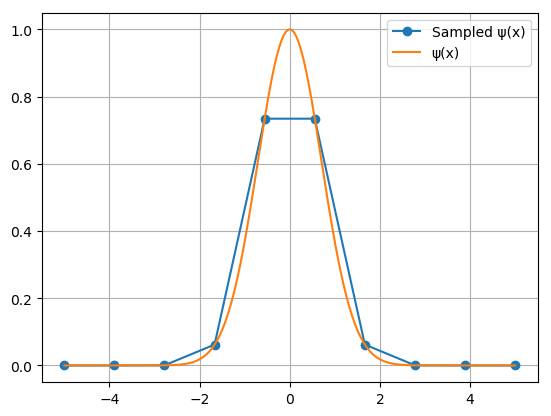

In [25]:
x_dense = range(x_min, x_max, length=500)
plt.clf()
plt.plot(x, my_gaussian.(x), marker="o", label="Sampled ψ(x)")
plt.plot(x_dense, my_gaussian.(x_dense), label="ψ(x)")
plt.grid()
plt.legend();

Now, think of sampled function values $\psi(x_{i})$ as a column vector and we want to find the value of $\psi''(x_{i})$.

We will use 2nd order finite difference to approximate $\dfrac{\mathrm{d}^2}{\mathrm{d}x^2}$ operator.

$$
\frac{\mathrm{d}^2}{\mathrm{d}x^2}\psi(x_{i}) \approx
\frac{ \psi(x_{i} + h) - 2\psi(x_{i}) + \psi(x_{i} - h)}{h^2}
$$

In matrix notation this operator can be represented as:

$$
D^{(2)} = \dfrac{1}{h^2}
\begin{bmatrix}
-2 & 1 & 0 & 0 & \cdots & 0 \\
1 & -2 & 1 & 0 & \cdots & 0 \\
0 & 1 & -2 & 1 & \cdots & 0 \\
\cdots & \cdots & \cdots & \cdots \\
0 & 0 & 0 & 1 & -2 & 1 \\
0 & 0 & 0 & 0 & 1 & -2 \\
\end{bmatrix}
$$


The approximate the values of $\psi''_{i}$ we can apply (multiply) the matrix $D^{(2)}$ to vector $\psi_{i}$

In [12]:
function build_D2_matrix(N::Int64, h::Float64)
    mat = zeros(Float64,N,N)
    for i = 1:N
        mat[i,i] = -2.0
        if i != N
            mat[i,i+1] = 1.0
            mat[i+1,i] = mat[i,i+1]
        end
    end
    return mat/h^2
end

build_D2_matrix (generic function with 1 method)

In [13]:
D2 = build_D2_matrix(N,h)

10×10 Array{Float64,2}:
 -1.62   0.81   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0 
  0.81  -1.62   0.81   0.0    0.0    0.0    0.0    0.0    0.0    0.0 
  0.0    0.81  -1.62   0.81   0.0    0.0    0.0    0.0    0.0    0.0 
  0.0    0.0    0.81  -1.62   0.81   0.0    0.0    0.0    0.0    0.0 
  0.0    0.0    0.0    0.81  -1.62   0.81   0.0    0.0    0.0    0.0 
  0.0    0.0    0.0    0.0    0.81  -1.62   0.81   0.0    0.0    0.0 
  0.0    0.0    0.0    0.0    0.0    0.81  -1.62   0.81   0.0    0.0 
  0.0    0.0    0.0    0.0    0.0    0.0    0.81  -1.62   0.81   0.0 
  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.81  -1.62   0.81
  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.81  -1.62

Let's try to approximate the 2nd derivative of $\psi(x)$.
Because we know the analytic form of $\psi(x)$, we can calculate its second derivative exactly.
We will compare our approximation with exact/analytic result.

The second derivative of $\psi(x)$ is:

$$
\psi''(x) = -2\alpha \text{e}^{-\alpha x^2} + 4\alpha^2 x^2 \text{e}^{-\alpha x^2}
$$

In [14]:
function d2_my_gaussian(x, α=1.0)
    return -2*α*exp(-α*x^2) + 4*α^2 * x^2 * exp(-α*x^2)
end

d2_my_gaussian (generic function with 2 methods)

Here, we calculate the 2nd derivative of $\psi$

In [15]:
psi = my_gaussian.(x)
d2_psi = D2*psi  # approximation, we using matrix multiplication here
d2_psi_exact = d2_my_gaussian.(x);

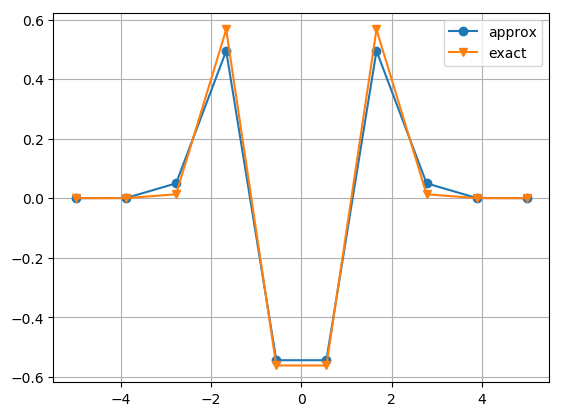

In [16]:
plt.clf()
plt.plot(x, d2_psi, marker="o", label="approx")
plt.plot(x, d2_psi_exact, marker="v", label="exact")
plt.grid()
plt.legend();

Let's try with more points.

### Using 50 points

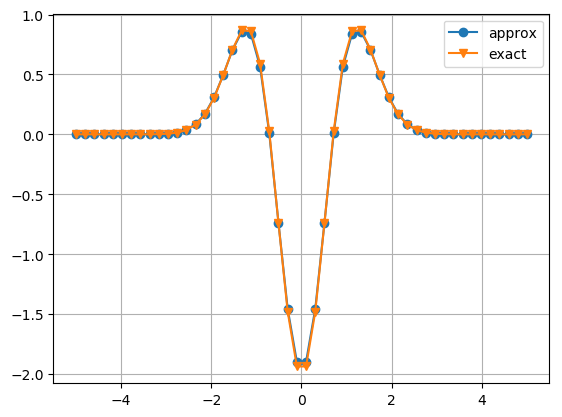

In [17]:
N = 50
x_min = -5.0
x_max = 5.0
L = x_max - x_min
h = L/(N-1)
x = zeros(Float64,N)
for i = 1:N
    x[i] = x_min + (i-1)*h
end

psi = my_gaussian.(x)
D2 = build_D2_matrix(N,h)
d2_psi = D2*psi
d2_psi_exact = d2_my_gaussian.(x)

plt.clf()
plt.plot(x, d2_psi, marker="o", label="approx")
plt.plot(x, d2_psi_exact, marker="v", label="exact")
plt.grid()
plt.legend();

Plot their differences:

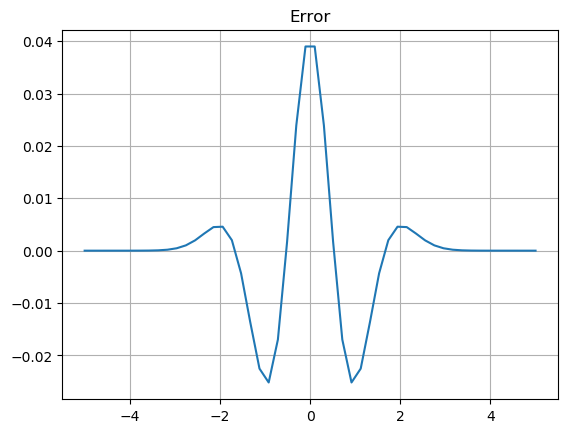

In [18]:
plt.clf()
plt.plot(x, d2_psi - d2_psi_exact)
plt.title("Error")
plt.grid();

The largest error is within the center. The error is in the order of $10^{-2}$. Note that the value of $h$ and $h^2$:

In [32]:
h, h^2

(0.20408163265306123, 0.04164931278633903)

The error should be in the order of $h^2$.

### Using 200 points

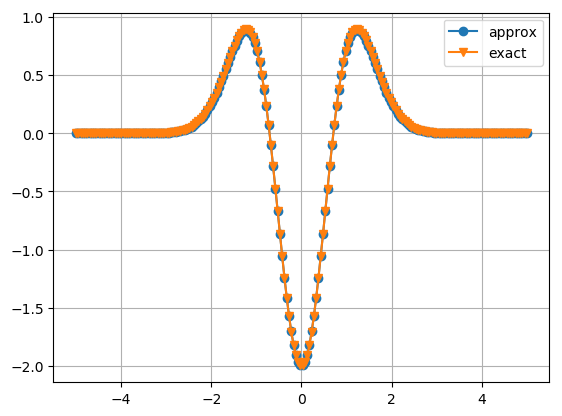

In [19]:
N = 200
x_min = -5.0
x_max = 5.0
L = x_max - x_min
h = L/(N-1)
x = zeros(Float64,N)
for i = 1:N
    x[i] = x_min + (i-1)*h
end

psi = my_gaussian.(x)
D2 = build_D2_matrix(N,h)
d2_psi = D2*psi
d2_psi_exact = d2_my_gaussian.(x)

plt.clf()
plt.plot(x, d2_psi, marker="o", label="approx")
plt.plot(x, d2_psi_exact, marker="v", label="exact")
plt.grid()
plt.legend();

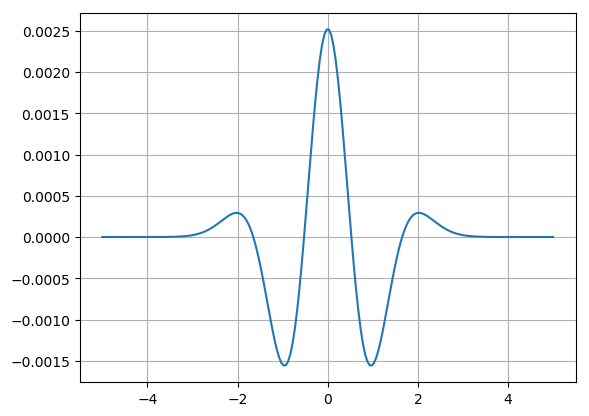

In [20]:
plt.clf()
plt.plot(x, d2_psi - d2_psi_exact)
plt.grid();

In [35]:
h, h^2

(0.05025125628140704, 0.0025251887578596503)

# Quantum-mechanical harmonic oscillator

Now that we can approximate second derivative we can start solving TISE.

We will consider harmonic potential:

$$
V(x) = \frac{1}{2}m \omega^2 x^2
$$

for which we have analytic solutions.

In the following, I will use Hartree unit, such that $\dfrac{h^2}{m} = 1$.

The eigenvalues $E_{n}$ are:

$$
E_{n} = \left( n + \frac{1}{2} \right) \hbar \omega
$$

with $n = 0, 1, 2, \ldots$.

Our main task is to build the Hamiltonian matrix with the elements:

$$
H_{ij} = -\frac{1}{2}D^{(2)}_{ij} + V(x_{i})\delta_{ij}
$$

In [21]:
function pot_harmonic(x, ω=1.0)
    return 0.5 * ω^2 * x^2
end

pot_harmonic (generic function with 2 methods)

Let's use, say 50 points (you may want to use another value).

In [22]:
N = 50
x_min = -5.0
x_max = 5.0
L = x_max - x_min
h = L/(N-1)
x = zeros(Float64,N)
for i = 1:N
    x[i] = x_min + (i-1)*h
end

D2 = build_D2_matrix(N,h);

In [23]:
V_harmonic = pot_harmonic.(x);

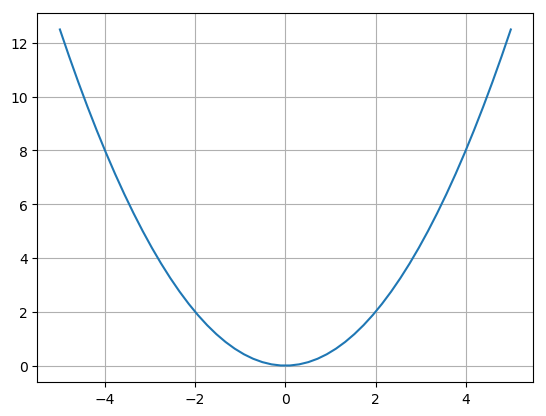

In [24]:
plt.clf()
plt.plot(x, V_harmonic)
plt.grid();

Now, let's build the Hamiltonian matrix and find its eigenvalues and eigenvectors:

In [25]:
Ham = zeros(Float64, N, N)
# set to kinetic operator first
Ham[:,:] = -0.5*D2 
# the add the potential term (diagonal)
for i = 1:N
    Ham[i,i] = Ham[i,i] + V_harmonic[i]
end
evals, evecs = eigen(Ham);

Print out 4 lowest eigenvalues:

In [26]:
evals[1:4]

4-element Array{Float64,1}:
 0.49869504420754396
 1.4934613991645307 
 2.4829591491765157 
 3.4671456055636156 

Compare these values with the analytic solutions of: $0.5, 1.5, 2.5, 3.5, \ldots$.

Now, let's try to plot the eigenvectors (the orbitals):

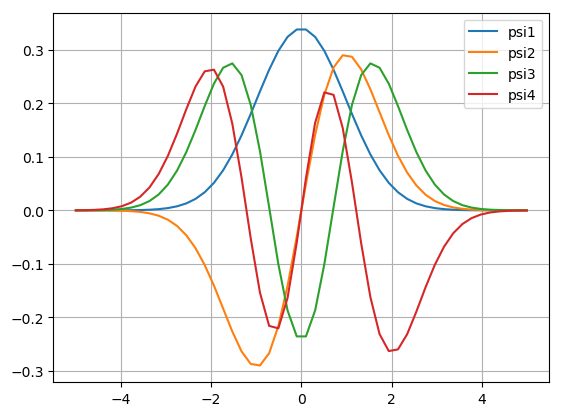

In [27]:
plt.clf()
plt.plot(x, evecs[:,1], label="psi1")
plt.plot(x, evecs[:,2], label="psi2")
plt.plot(x, evecs[:,3], label="psi3")
plt.plot(x, evecs[:,4], label="psi4")
plt.grid()
plt.legend();

Note that the eigenvectors are orthonormal:

In [46]:
dot( evecs[:,1], evecs[:,1] )

1.0

In [47]:
dot( evecs[:,1], evecs[:,2] )

3.390344712528086e-15

In [48]:
dot( evecs[:,2], evecs[:,2] )

1.0000000000000002

In [49]:
dot( evecs[:,2], evecs[:,3] )

-1.563790635249762e-14

## Convergence of eigenvalues with respect to number of points

In [28]:
function calc_evals(N, N_evals=1)
    x_min = -5.0
    x_max = 5.0
    L = x_max - x_min
    h = L/(N-1)
    x = zeros(Float64,N)
    for i = 1:N
        x[i] = x_min + (i-1)*h
    end
    D2 = build_D2_matrix(N,h);
    V_harmonic = pot_harmonic.(x);
    Ham = -0.5*D2 + diagm(0 => V_harmonic)
    evals = eigvals(Ham)
    return h, evals[1:N_evals]
end

calc_evals (generic function with 2 methods)

In [29]:
N0 = 20
ΔN = 10
Ntry = 30
λ_prev = 0.0
λ_exact = 0.5
# for plotting
h_plt = Array{Float64}([])
Δλex_plt = Array{Float64}([])
#
for i = 1:Ntry
    N = N0 + (i-1)*ΔN
    h, λ = calc_evals(N)
    Δλex = abs(λ[1]-λ_exact)
    @printf("%8d %18.10f %18.10f %12.5e\n", N, h, λ[1], Δλex)
    #
    append!(h_plt, h)
    append!(Δλex_plt, Δλex)
end

      20       0.5263157895       0.4911851752  8.81482e-03
      30       0.3448275862       0.4962559342  3.74407e-03
      40       0.2564102564       0.4979368821  2.06312e-03
      50       0.2040816327       0.4986950442  1.30496e-03
      60       0.1694915254       0.4991006489  8.99351e-04
      70       0.1449275362       0.4993427602  6.57240e-04
      80       0.1265822785       0.4994987760  5.01224e-04
      90       0.1123595506       0.4996051671  3.94833e-04
     100       0.1010101010       0.4996809513  3.19049e-04
     110       0.0917431193       0.4997368365  2.63164e-04
     120       0.0840336134       0.4997792260  2.20774e-04
     130       0.0775193798       0.4998121402  1.87860e-04
     140       0.0719424460       0.4998382066  1.61793e-04
     150       0.0671140940       0.4998592010  1.40799e-04
     160       0.0628930818       0.4998763588  1.23641e-04
     170       0.0591715976       0.4998905611  1.09439e-04
     180       0.0558659218       0.4999

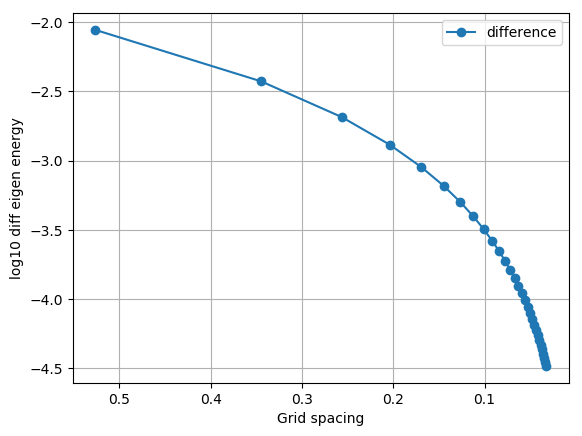

In [30]:
plt.clf()
plt.plot(h_plt, log10.(Δλex_plt), label="difference", marker="o")
plt.grid()
plt.gca().invert_xaxis() # invert the x-axis
plt.xlabel("Grid spacing")
plt.ylabel("log10 diff eigen energy")
plt.legend();

## Using higher order finite difference

TODO

# Gaussian potential

Attractive Gaussian potential.

In [78]:
function pot_gaussian(x; A=1.0, x0=0.0, α=1.0)
    return -A*exp(-α*(x-x0)^2)
end

pot_gaussian (generic function with 1 method)

Some test:

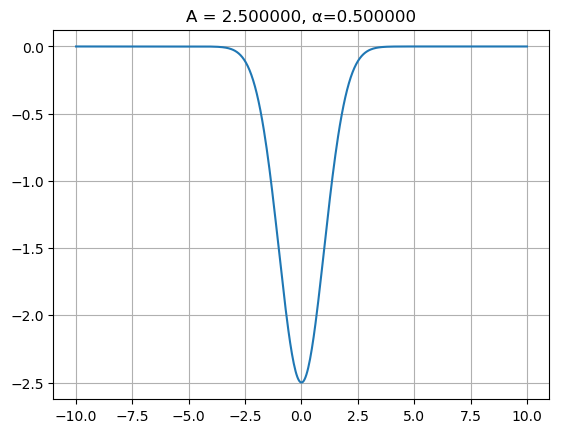

[-1.80391, -0.636082, -0.016816, 0.066028]


In [104]:
N = 500
x_min = -10.0
x_max = 10.0
L = x_max - x_min
h = L/(N-1)
x = zeros(Float64,N)
for i = 1:N
    x[i] = x_min + (i-1)*h
end

A = 2.5
α = 0.5
D2 = build_D2_matrix(N,h);
V_gaussian = pot_gaussian.(x, A=A, α=α);

plt.clf()
plt.plot(x, V_gaussian)
plt.title(@sprintf("A = %f, α=%f", A, α))
plt.grid()

Ham = -0.5*D2 + diagm(0 => V_gaussian)
evals, evecs = eigen(Ham);
println(evals[1:4])

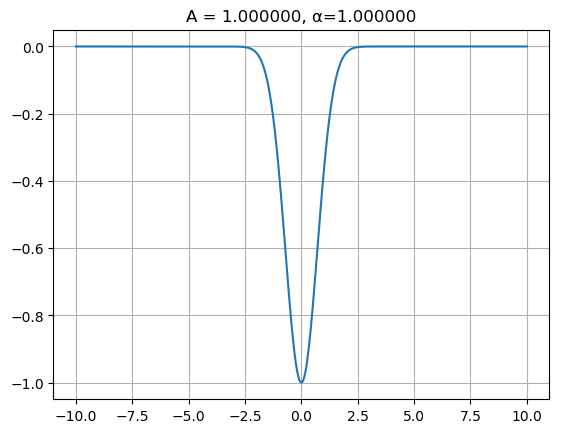

[-0.477425, 0.0316396, 0.062141, 0.150922]


In [103]:
N = 500
x_min = -10.0
x_max = 10.0
L = x_max - x_min
h = L/(N-1)
x = zeros(Float64,N)
for i = 1:N
    x[i] = x_min + (i-1)*h
end

A = 1.0
α = 1.0
D2 = build_D2_matrix(N,h);
V_gaussian = pot_gaussian.(x, A=A, α=α);

plt.clf()
plt.plot(x, V_gaussian)
plt.title(@sprintf("A = %f, α=%f", A, α))
plt.grid()

Ham = -0.5*D2 + diagm(0 => V_gaussian)
evals, evecs = eigen(Ham);
println(evals[1:4])

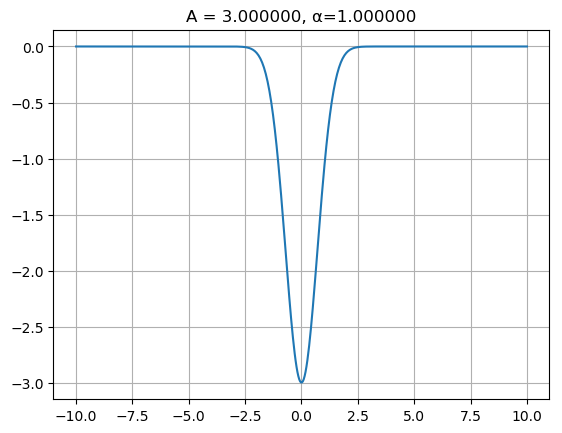

[-1.96389, -0.370225, 0.0469122, 0.0715078]


In [100]:
N = 500
x_min = -10.0
x_max = 10.0
L = x_max - x_min
h = L/(N-1)
x = zeros(Float64,N)
for i = 1:N
    x[i] = x_min + (i-1)*h
end

A = 3.0
α = 1.0
D2 = build_D2_matrix(N,h);
V_gaussian = pot_gaussian.(x, A=A, α=α);

plt.clf()
plt.plot(x, V_gaussian)
plt.title(@sprintf("A = %f, α=%f", A, α))
plt.grid()

Ham = -0.5*D2 + diagm(0 => V_gaussian)
evals, evecs = eigen(Ham);
println(evals[1:4])

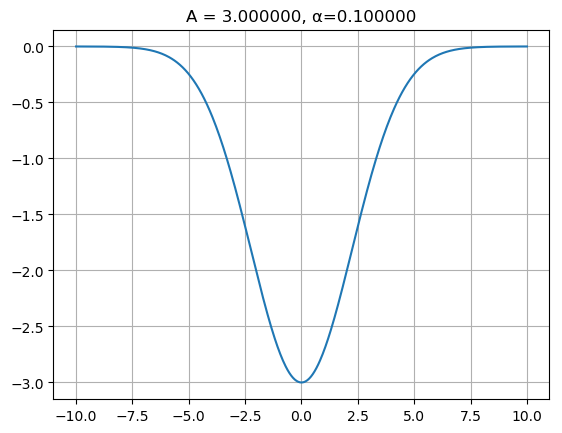

[-2.63156, -1.93473, -1.32134, -0.799672]


In [99]:
N = 500
x_min = -10.0
x_max = 10.0
L = x_max - x_min
h = L/(N-1)
x = zeros(Float64,N)
for i = 1:N
    x[i] = x_min + (i-1)*h
end
A = 3.0
α = 0.1
D2 = build_D2_matrix(N,h);
V_gaussian = pot_gaussian.(x, A=A, α=α);

plt.clf()
plt.plot(x, V_gaussian)
plt.title(@sprintf("A = %f, α=%f", A, α))
plt.grid()

Ham = -0.5*D2 + diagm(0 => V_gaussian)
evals, evecs = eigen(Ham);
println(evals[1:4])

## Two centers

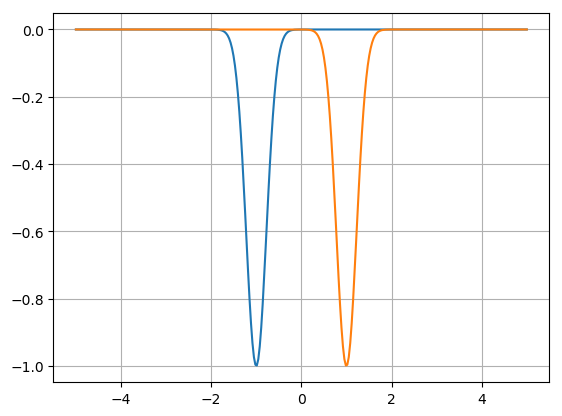

In [77]:
V1 = gaussian_pot.(x, x0=-1.0, α=10.0)
V2 = gaussian_pot.(x, x0=1.0, α=10.0)
plt.clf()
plt.plot(x, V1)
plt.plot(x, V2)
plt.grid();